In [54]:
import functools
import itertools
import logging
import math
import os
import pickle
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import yaml

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_context("poster")
sns.set(rc={"figure.figsize": (16, 12.0)})
sns.set_style("whitegrid")

import numpy as np
import pandas as pd
import torch.nn.functional as F

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from lda4rec.datasets import Interactions, DataLoader, random_train_test_split
from lda4rec.evaluations import mrr_score, precision_recall_score, auc_score, summary
from lda4rec.estimators import BilinearBPREst, PopEst, LDA4RecEst, PosBilinearEst, LDA4RecEst

In [56]:
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.distributions import constraints
from pyro.infer import SVI, Predictive, Trace_ELBO, TraceEnum_ELBO, config_enumerate

In [57]:
import neptune
# init dummy neptune to avoid problems with logging
neptune.init('a/b', backend=neptune.OfflineBackend()) 

In [195]:
from itertools import product

In [224]:
a = product(*{"a": [1,2,3], "b": [4,5,6]}.values())

In [228]:
next(a)

(2, 4)

In [58]:
from icecream import ic, install

install()
# configure icecream
def ic_str(obj):
    if hasattr(obj, "shape"):
        return f"Shape {obj.shape} "  #
    else:
        return str(obj)

In [183]:
idx=3
f"exp_{idx:0>5}.yaml"

'exp_00003.yaml'

[0.26894142 0.73105858]
1.0


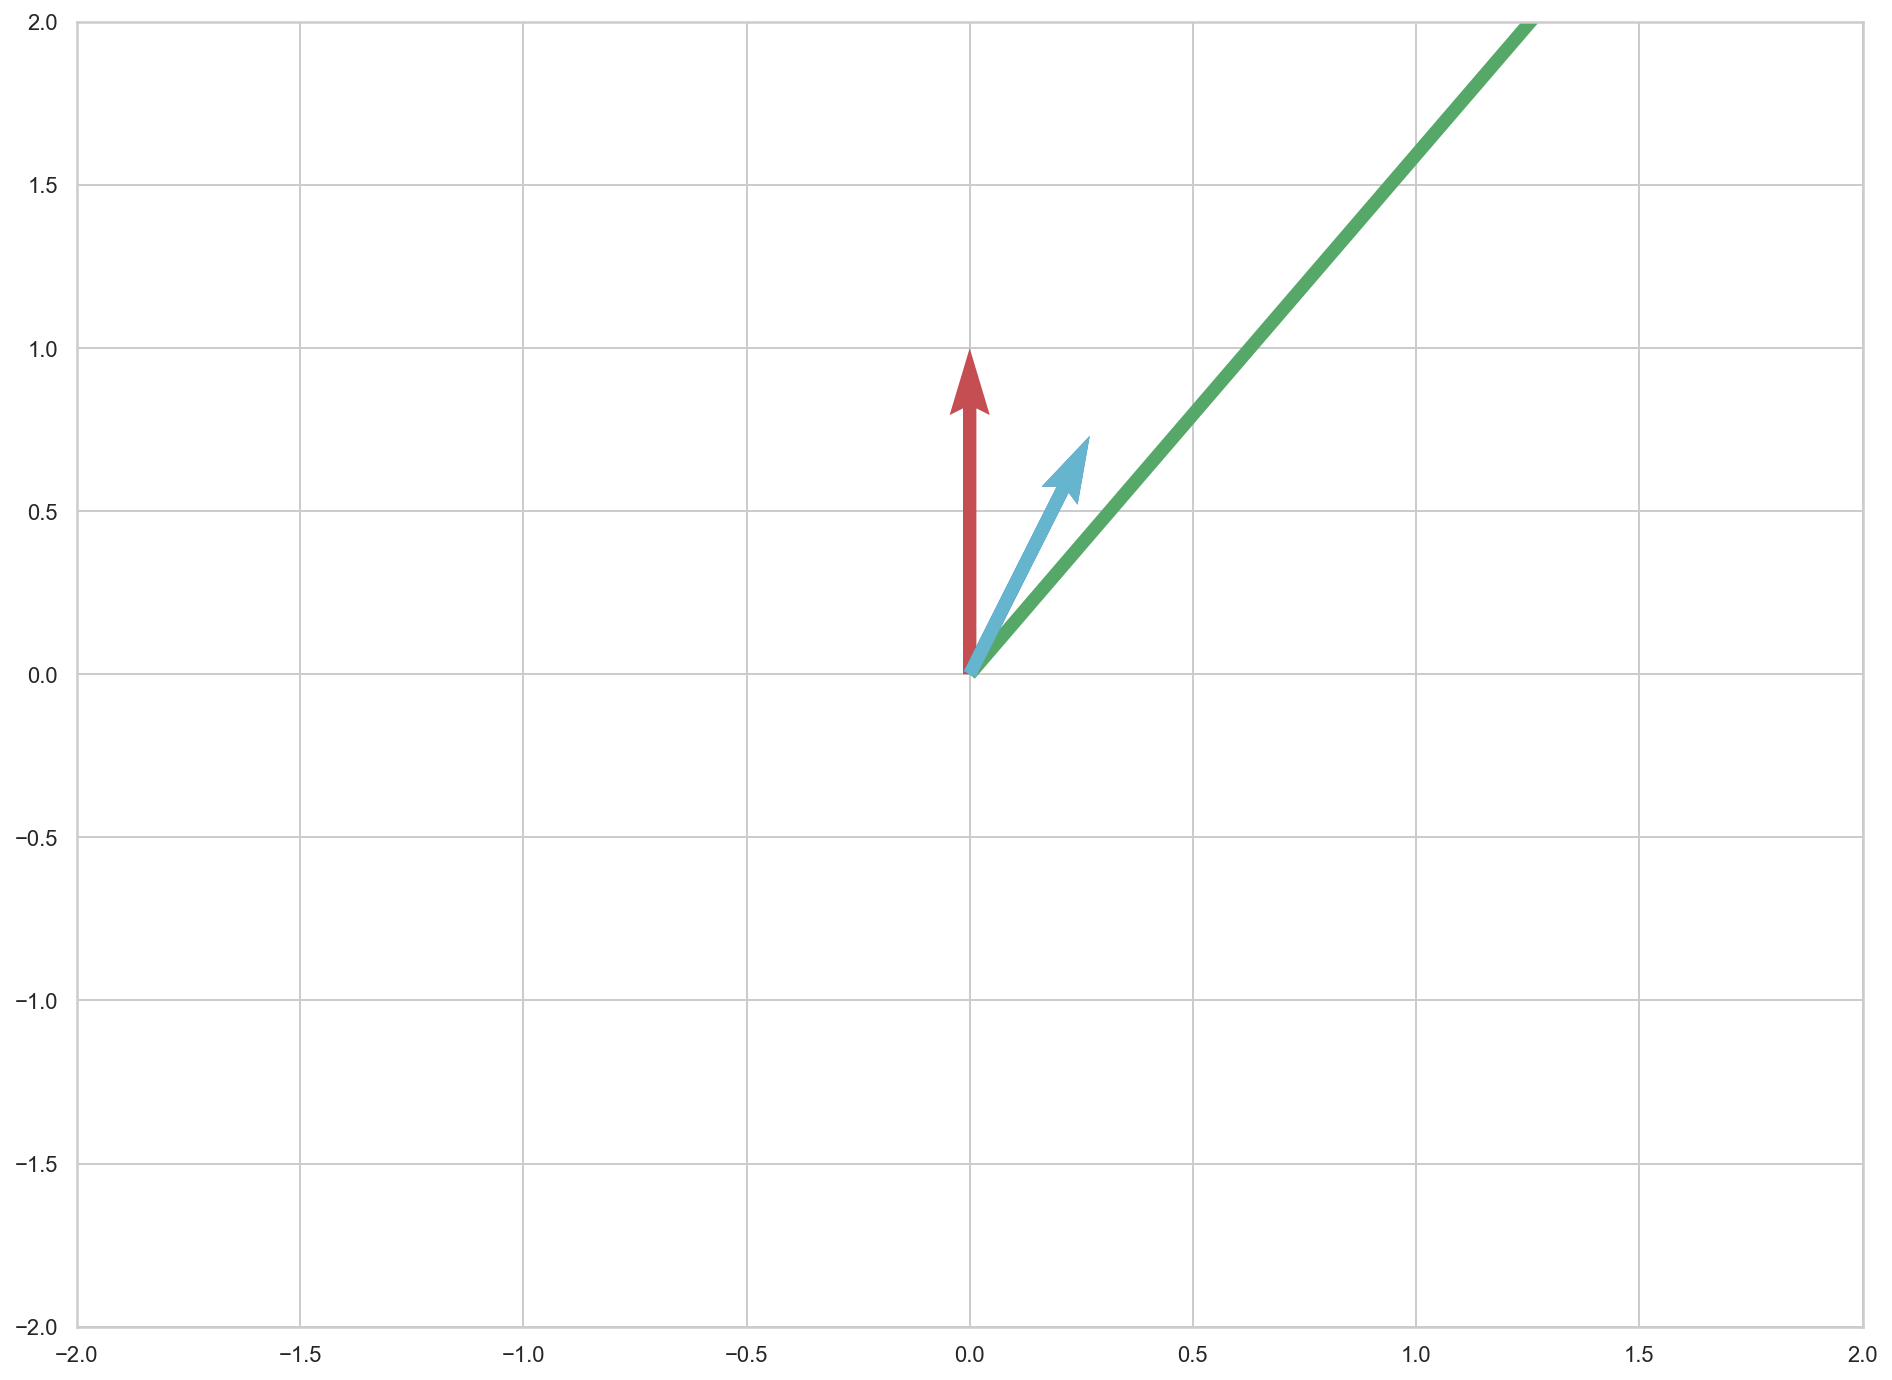

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    return np.exp(x)/sum(np.exp(x))

a = np.array([0.,1])
s = softmax(a)
V = np.vstack([a, s, np.log(s)+3, softmax(np.log(s)+3)])
print(softmax(a))
print((a*a).sum())
origin = np.array([[0, 0, 0, 0],[0, 0, 0, 0]]) # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g', 'c'], scale=1, angles='xy', scale_units='xy')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

array([[1, 1],
       [1, 1]])

In [192]:
ic.configureOutput(argToStringFunction=ic_str)

In [60]:
loader = DataLoader()
data = loader.load_movielens("100k")

In [61]:
max_interactions = 200
data.max_user_interactions_(max_interactions)

In [62]:
data.implicit_(0.)
train, test = random_train_test_split(data)

In [63]:
pop_est = PopEst()
pop_est.fit(train)

In [64]:
summary(pop_est, train=train, test=test)

,train,test
metric,,
prec,0.287213,0.102787
recall,0.052746,0.073974
mrr,0.025483,0.039039
auc,0.910499,0.875768


In [189]:
lda_est = LDA4RecEst(embedding_dim=4, n_iter=1000, batch_size=128, learning_rate=0.01, use_jit=True, alpha=1.)

In [190]:
lda_est.fit(train)

INFO:lda4rec.estimators:Epoch     0: loss 512758.96875
INFO:lda4rec.estimators:Epoch   100: loss 428761.8125
INFO:lda4rec.estimators:Epoch   200: loss 417006.46875
INFO:lda4rec.estimators:Epoch   300: loss 385486.15625
INFO:lda4rec.estimators:Epoch   400: loss 378263.90625
INFO:lda4rec.estimators:Epoch   500: loss 408196.25
INFO:lda4rec.estimators:Epoch   600: loss 361898.875
INFO:lda4rec.estimators:Epoch   700: loss 322253.0625
INFO:lda4rec.estimators:Epoch   800: loss 351111.8125
INFO:lda4rec.estimators:Epoch   900: loss 400399.9375


408908.53125

In [194]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.361639,0.150328
recall,0.070594,0.110738
mrr,0.032923,0.050490
auc,0.937884,0.910573


In [113]:
summary(lda_est, train=train, test=test)

,train,test
metric,,
prec,0.354590,0.143279
recall,0.068321,0.102013
mrr,0.032243,0.048016
auc,0.940035,0.906986


In [56]:
bi_est = BilinearEst(embedding_dim=8, n_iter=10)
bi_est.fit(ml100k_train)
bi_est._model.user_biases(torch.ones(1, dtype=torch.int))


INFO:lda4rec.estimators:Epoch 0: loss 0.3863141273324554
INFO:lda4rec.estimators:Epoch 1: loss 0.16275720398973775
INFO:lda4rec.estimators:Epoch 2: loss 0.11302756932941643
INFO:lda4rec.estimators:Epoch 3: loss 0.09363524680202072
INFO:lda4rec.estimators:Epoch 4: loss 0.08213316621007145
INFO:lda4rec.estimators:Epoch 5: loss 0.07402117036887117
INFO:lda4rec.estimators:Epoch 6: loss 0.06968047533788391
INFO:lda4rec.estimators:Epoch 7: loss 0.06699451271041824
INFO:lda4rec.estimators:Epoch 8: loss 0.061449452721186584
INFO:lda4rec.estimators:Epoch 9: loss 0.061370197935281576


tensor([[0.]], grad_fn=<EmbeddingBackward>)

In [48]:
bi_est._model.user_embeddings(torch.ones(1, dtype=torch.int))

tensor([[ 2.4484, -2.1536, -2.6832, -2.1182, -0.4593, -2.4951, -3.5172, -2.9929]],
       grad_fn=<EmbeddingBackward>)

In [49]:
summary(bi_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.311311,0.115082
recall,0.057052,0.078730
mrr,0.027751,0.038735
auc,0.943094,0.894530


In [29]:
slra_est = SimplePosBilinearEst(embedding_dim=8, n_iter=25)
slra_est.fit(ml100k_train)

INFO:lda4rec.estimators:Epoch 0: loss 0.39755058497995943
INFO:lda4rec.estimators:Epoch 1: loss 0.1931836449012563
INFO:lda4rec.estimators:Epoch 2: loss 0.1379744282244025
INFO:lda4rec.estimators:Epoch 3: loss 0.12481177019307742
INFO:lda4rec.estimators:Epoch 4: loss 0.11623588691692094
INFO:lda4rec.estimators:Epoch 5: loss 0.1061518636708324
INFO:lda4rec.estimators:Epoch 6: loss 0.09778834418267818
INFO:lda4rec.estimators:Epoch 7: loss 0.09306149701210292
INFO:lda4rec.estimators:Epoch 8: loss 0.08847690053485535
INFO:lda4rec.estimators:Epoch 9: loss 0.08227667711876534
INFO:lda4rec.estimators:Epoch 10: loss 0.0780268491522686
INFO:lda4rec.estimators:Epoch 11: loss 0.0744348161828679
INFO:lda4rec.estimators:Epoch 12: loss 0.07145940351325113
INFO:lda4rec.estimators:Epoch 13: loss 0.06839842264716689
INFO:lda4rec.estimators:Epoch 14: loss 0.06768081353826297
INFO:lda4rec.estimators:Epoch 15: loss 0.06565732044243329
INFO:lda4rec.estimators:Epoch 16: loss 0.06112832646514919
INFO:lda4rec

0.05322646721190698

In [30]:
summary(slra_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.331967,0.129508
recall,0.061089,0.092829
mrr,0.029249,0.041842
auc,0.964879,0.903955


In [33]:
lra_est = PosBilinearEst(embedding_dim=8, n_iter=25)
lra_est.fit(ml100k_train)

INFO:lda4rec.estimators:Epoch 0: loss 0.47544069531801586
INFO:lda4rec.estimators:Epoch 1: loss 0.22211888790936082
INFO:lda4rec.estimators:Epoch 2: loss 0.14464610694227992
INFO:lda4rec.estimators:Epoch 3: loss 0.126111490219026
INFO:lda4rec.estimators:Epoch 4: loss 0.11476287563910355
INFO:lda4rec.estimators:Epoch 5: loss 0.11025619404138745
INFO:lda4rec.estimators:Epoch 6: loss 0.10320340022444725
INFO:lda4rec.estimators:Epoch 7: loss 0.09600494869456098
INFO:lda4rec.estimators:Epoch 8: loss 0.09058575598976097
INFO:lda4rec.estimators:Epoch 9: loss 0.08669685620713878
INFO:lda4rec.estimators:Epoch 10: loss 0.08124634907455058
INFO:lda4rec.estimators:Epoch 11: loss 0.07881147558423313
INFO:lda4rec.estimators:Epoch 12: loss 0.07593562307994108
INFO:lda4rec.estimators:Epoch 13: loss 0.07219354410127209
INFO:lda4rec.estimators:Epoch 14: loss 0.07037132109037122
INFO:lda4rec.estimators:Epoch 15: loss 0.06985558191112973
INFO:lda4rec.estimators:Epoch 16: loss 0.06477439438773168
INFO:lda4

0.054229231533669944

In [38]:
lra_est._model.user_embeddings(torch.ones(1, dtype=torch.int))

tensor([[-0.5403, -4.8071, -6.7378, -3.8542,  1.3193,  2.0219,  0.3636, -2.2575]],
       grad_fn=<EmbeddingBackward>)

In [34]:
summary(lra_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.330820,0.121311
recall,0.062423,0.083869
mrr,0.029859,0.039169
auc,0.961974,0.899659


In [12]:
summary(lra_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.309016,0.119540
recall,0.056212,0.085363
mrr,0.029178,0.040881
auc,0.961975,0.914103


In [21]:
summary(lra_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.349836,0.126885
recall,0.066229,0.090332
mrr,0.031398,0.042569
auc,0.962789,0.905485


In [19]:
lda_est = LDA4RecEst(params=pyro.get_param_store(), n_items=ml100k.n_items)

In [13]:
summary(lra_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.327541,0.109016
recall,0.062915,0.077158
mrr,0.030026,0.036842
auc,0.965750,0.900079


In [21]:
summary(lda_est, train=ml100k_train, test=ml100k_test)

,train,test
metric,,
prec,0.349344,0.141148
recall,0.068502,0.100990
mrr,0.032233,0.045185
auc,0.938877,0.908419


In [123]:
dist.Dirichlet(torch.tensor([0.001,0.01])).sample((10_000,)).mean(axis=0)

tensor([0.0884, 0.9116])

In [60]:
n_samples = 200
rng = np.random.default_rng(42)
model_params["interactions"] = data.interactions

predictive = Predictive(model, guide=guide, num_samples=n_samples)
samples = {
    k: v.detach().cpu().numpy()
    for k, v in predictive(**model_params).items()
}

IndexError: index 1 is out of bounds for dimension 0 with size 1